<a href="https://colab.research.google.com/github/malihasama07/Python/blob/main/Hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')

In [3]:
print("Shape:", df.shape)
df.head()

Shape: (200, 3)


,feature1,feature2,target
0,-0.872929,0.013042,1
1,1.312935,2.770534,1
2,2.340428,2.420996,1
3,2.294548,-0.404380,1
4,0.944105,0.477241,1


In [4]:
print("Columns:", df.columns.tolist())

Columns: ['feature1', 'feature2', 'target']


In [5]:
print("Description:")
display(df.describe())

Description:


,feature1,feature2,target
count,200.000000,200.000000,200.000000
mean,0.127291,0.998048,0.500000
std,1.448313,1.029297,0.501255
min,-3.121909,-1.221998,0.000000
25%,-0.886754,0.353238,0.000000
50%,0.100130,0.866166,0.500000
75%,1.110329,1.679383,1.000000
max,3.663322,4.484226,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  200 non-null    float64
 1   feature2  200 non-null    float64
 2   target    200 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 4.8 KB


In [7]:
print("Missing values in each column:\n")
print(df.isnull().sum())

Missing values in each column:

feature1    0
feature2    0
target      0
dtype: int64


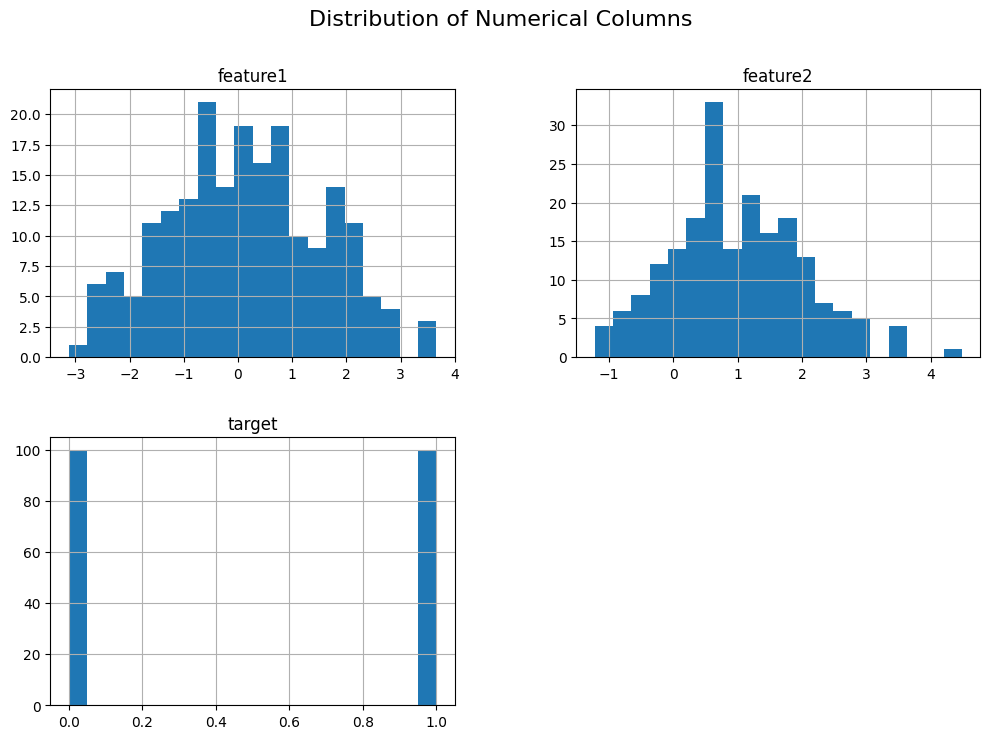

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribution of Numerical Columns", size=16)
plt.show()


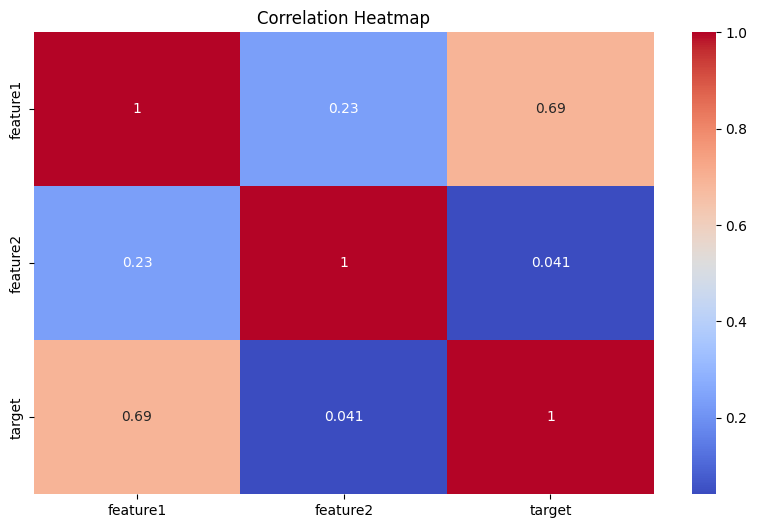

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


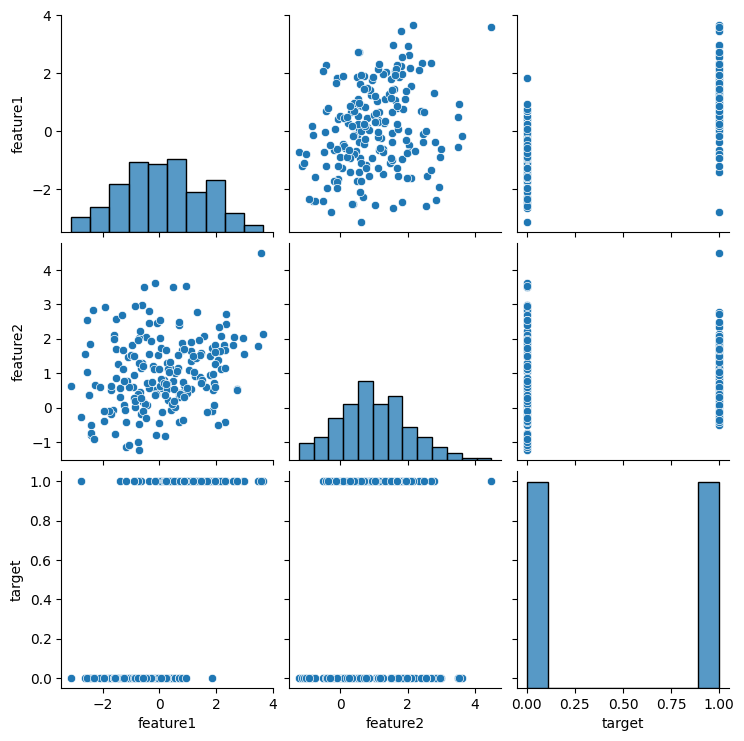

In [10]:
sns.pairplot(df)
plt.show()


In [11]:

id_like = [c for c in df.columns if c.lower() in ('id','index','uid','serial')]
date_like = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
print("Possible id columns:", id_like)
print("Possible date columns:", date_like)

target = 'target' if 'target' in df.columns else None
print("Detected target:", target)


Possible id columns: []
Possible date columns: []
Detected target: target


In [12]:

n_dup = df.duplicated().sum()
print("duplicate rows:", n_dup)
if n_dup > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates. New shape:", df.shape)


str_cols = df.select_dtypes(include=['object']).columns.tolist()
df[str_cols] = df[str_cols].apply(lambda s: s.str.strip())


duplicate rows: 0


In [13]:

for c in date_like:
    df[c] = pd.to_datetime(df[c], errors='coerce')

    df[c + "_year"] = df[c].dt.year
    df[c + "_month"] = df[c].dt.month
    df[c + "_day"] = df[c].dt.day
    df[c + "_dow"] = df[c].dt.dayofweek
print("Added simple date features for:", date_like)


Added simple date features for: []


In [15]:
mv = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_count": df.isnull().sum(),
    "missing_pct": (df.isnull().mean()*100),
    "nunique": df.nunique(dropna=True)
}).sort_values("missing_pct", ascending=False)
display(mv)


,dtype,missing_count,missing_pct,nunique
feature1,float64,0,0.0,200
feature2,float64,0,0.0,200
target,int64,0,0.0,2


In [16]:
for c in df.columns:
    if df[c].isnull().any():
        df[c + "_missing_flag"] = df[c].isnull().astype(int)


In [17]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
outlier_info = {}
for c in num_cols:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    high = Q3 + 1.5*IQR
    n_out = ((df[c] < low) | (df[c] > high)).sum()
    outlier_info[c] = {"low": low, "high": high, "n_outliers": int(n_out)}
pd.DataFrame(outlier_info).T.sort_values("n_outliers", ascending=False).head(20)


,low,high,n_outliers
feature2,-1.635980,3.668600,1.0
feature1,-3.882378,4.105954,0.0
target,-1.500000,2.500000,0.0


In [18]:
from sklearn.model_selection import train_test_split

if target is not None:
    X = df.drop(columns=[target]).copy()
    y = df[target].copy()

    strat = y if (y.nunique() > 1 and str(y.dtype) != 'float') else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=strat)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
else:

    X_train = df.copy()
    print("No target provided — operating unsupervised.")


Train shape: (160, 2) Test shape: (40, 2)


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder


num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()
print("numeric cols:", num_cols)
print("categorical cols:", cat_cols)


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)


numeric cols: ['feature1', 'feature2']
categorical cols: []


In [20]:

preprocessor.fit(X_train)


X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test) if target is not None else preprocessor.transform(X_train)

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)


num_names = num_cols
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_names = []
if len(cat_cols) > 0:
    try:
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    except Exception:
        ohe_names = [f"{c}_{i}" for c in cat_cols for i in range(1)]  # fallback
feature_names = num_names + ohe_names
print("Number of final features:", len(feature_names))

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
display(X_train_df.head())


Processed train shape: (160, 2)
Processed test shape: (40, 2)
Number of final features: 2


,feature1,feature2
99,-1.917542,0.498500
155,-0.714728,-0.071889
146,-0.432501,-0.841257
0,-0.688023,-0.927673
124,1.152613,-0.061315


In [21]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib

if target is not None:

    if y_train.dtype.kind in 'biu' or y_train.nunique() <= 20:  # crude heuristic
        model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    else:
        model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

    clf_pipeline = Pipeline([
        ('preproc', preprocessor),
        ('model', model)
    ])


    clf_pipeline.fit(X_train, y_train)

    joblib.dump(clf_pipeline, "final_pipeline.joblib")
    print("Saved pipeline to final_pipeline.joblib")


    y_pred = clf_pipeline.predict(X_test)
    if isinstance(model, RandomForestClassifier):
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        print("Test accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    else:
        from sklearn.metrics import mean_squared_error, r2_score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print("Test RMSE:", rmse, "R2:", r2_score(y_test, y_pred))
else:

    joblib.dump(preprocessor, "preprocessor.joblib")
    print("Saved preprocessor to preprocessor.joblib")


Saved pipeline to final_pipeline.joblib
Test accuracy: 0.9
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

Confusion matrix:
 [[17  3]
 [ 1 19]]
